This example shows how to use a `GridInducingVariationalGP` module. This classification module is designed for when the function you're modeling has 2-3 dimensional inputs and you don't believe that the output can be additively decomposed.
# Need clarification on additive classification again


In this example, the function is checkerboard of 1/3x1/3 squares with labels of -1 or 1


 Here we use KISS-GP (https://arxiv.org/pdf/1503.01057.pdf) to classify

In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt


%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from torch.autograd import Variable

# We make an nxn grid of training points
# In [0,1]x[0,1] spaced every 1/(n-1)
n = 30
train_x = torch.zeros(int(pow(n, 2)), 2)
train_y = torch.zeros(int(pow(n, 2)))
for i in range(n):
    for j in range(n):
        train_x[i * n + j][0] = float(i) / (n - 1)
        train_x[i * n + j][1] = float(j) / (n - 1)
        # True function is checkerboard of 1/3x1/3 squares with labels of -1 or 1
        train_y[i * n + j] = pow(-1, int(3 * i / n + int(3 * j / n)))
train_x = Variable(train_x)
train_y = Variable(train_y)

In [3]:
from torch import nn, optim
from gpytorch.kernels import RBFKernel, GridInterpolationKernel
from gpytorch.means import ConstantMean
from gpytorch.likelihoods import GaussianLikelihood, BernoulliLikelihood
from gpytorch.random_variables import GaussianRandomVariable

In [4]:
# Our classification model is just KISS-GP run through a Bernoulli likelihood
class GPClassificationModel(gpytorch.models.GridInducingVariationalGP):
    def __init__(self):
        super(GPClassificationModel, self).__init__(grid_size=10, grid_bounds=[(0, 1), (0, 1)])
        # Near-zero mean
        self.mean_module = ConstantMean(constant_bounds=[-1e-5, 1e-5])
        # RBF as universal approximator
        self.covar_module = RBFKernel(log_lengthscale_bounds=(-5, 6))
        self.register_parameter('log_outputscale', nn.Parameter(torch.Tensor([0])), bounds=(-5,6))
        
    def forward(self,x):
        # Learned mean is near-zero
        mean_x = self.mean_module(x)
        # Get predictive and scale
        covar_x = self.covar_module(x)
        covar_x = covar_x.mul(self.log_outputscale.exp())
        # Store as Gaussian
        latent_pred = GaussianRandomVariable(mean_x, covar_x)
        return latent_pred

# Initialize classification model
model = GPClassificationModel()
# Likelihood is Bernoulli, warm predictive mean 
likelihood = BernoulliLikelihood()

In [5]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},
    # BernoulliLikelihood has no parameters
], lr=0.1)

# "Loss" for GPs - the marginal log likelihood
# n_data refers to the amount of training data
mll = gpytorch.mlls.VariationalMarginalLogLikelihood(likelihood, model, n_data=len(train_y))

def train():
    num_training_iterations = 200
    for i in range(num_training_iterations):
        # zero back propped gradients
        optimizer.zero_grad()
        # Make  prediction
        output = model(train_x)
        # Calc loss and use to compute derivatives
        loss = -mll(output, train_y)
        loss.backward()
        print('Iter %d/%d - Loss: %.3f   log_lengthscale: %.3f' % (
            i + 1, num_training_iterations, loss.data[0],
            model.covar_module.base_kernel_module.log_lengthscale.data.squeeze()[0],
        ))
        optimizer.step()
%time train()

Iter 1/200 - Loss: 227.873   log_lengthscale: 0.000
Iter 2/200 - Loss: 88.907   log_lengthscale: -0.100
Iter 3/200 - Loss: 40.228   log_lengthscale: -0.198
Iter 4/200 - Loss: 32.330   log_lengthscale: -0.287
Iter 5/200 - Loss: 29.445   log_lengthscale: -0.371
Iter 6/200 - Loss: 19.748   log_lengthscale: -0.451
Iter 7/200 - Loss: 12.542   log_lengthscale: -0.527
Iter 8/200 - Loss: 8.304   log_lengthscale: -0.596
Iter 9/200 - Loss: 6.388   log_lengthscale: -0.661
Iter 10/200 - Loss: 5.698   log_lengthscale: -0.720
Iter 11/200 - Loss: 5.237   log_lengthscale: -0.775
Iter 12/200 - Loss: 4.971   log_lengthscale: -0.826
Iter 13/200 - Loss: 4.409   log_lengthscale: -0.873
Iter 14/200 - Loss: 4.295   log_lengthscale: -0.917
Iter 15/200 - Loss: 3.821   log_lengthscale: -0.958
Iter 16/200 - Loss: 3.523   log_lengthscale: -0.996
Iter 17/200 - Loss: 3.133   log_lengthscale: -1.031
Iter 18/200 - Loss: 2.878   log_lengthscale: -1.064
Iter 19/200 - Loss: 2.964   log_lengthscale: -1.095
Iter 20/200 - 

Iter 160/200 - Loss: 0.622   log_lengthscale: -1.585
Iter 161/200 - Loss: 0.625   log_lengthscale: -1.586
Iter 162/200 - Loss: 0.638   log_lengthscale: -1.587
Iter 163/200 - Loss: 0.609   log_lengthscale: -1.588
Iter 164/200 - Loss: 0.625   log_lengthscale: -1.589
Iter 165/200 - Loss: 0.620   log_lengthscale: -1.591
Iter 166/200 - Loss: 0.600   log_lengthscale: -1.592
Iter 167/200 - Loss: 0.637   log_lengthscale: -1.593
Iter 168/200 - Loss: 0.645   log_lengthscale: -1.594
Iter 169/200 - Loss: 0.620   log_lengthscale: -1.595
Iter 170/200 - Loss: 0.618   log_lengthscale: -1.597
Iter 171/200 - Loss: 0.625   log_lengthscale: -1.598
Iter 172/200 - Loss: 0.618   log_lengthscale: -1.599
Iter 173/200 - Loss: 0.613   log_lengthscale: -1.600
Iter 174/200 - Loss: 0.606   log_lengthscale: -1.601
Iter 175/200 - Loss: 0.600   log_lengthscale: -1.603
Iter 176/200 - Loss: 0.618   log_lengthscale: -1.604
Iter 177/200 - Loss: 0.638   log_lengthscale: -1.605
Iter 178/200 - Loss: 0.607   log_lengthscale: 

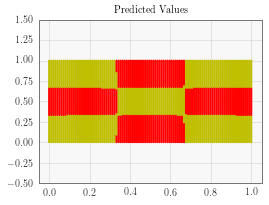

In [9]:
# Set model and likelihood into eval mode
model.eval()
likelihood.eval()

# Initialize figiure an axis
f, observed_ax = plt.subplots(1, 1, figsize=(4, 3))
# Test points are 100x100 grid of [0,1]x[0,1] with spacing of 1/99
n = 100
test_x = Variable(torch.zeros(int(pow(n, 2)), 2))
for i in range(n):
    for j in range(n):
        test_x.data[i * n + j][0] = float(i) / (n-1)
        test_x.data[i * n + j][1] = float(j) / (n-1)
        
# Make binary predictions by warmping the model output through a Bernoulli likelihood
with gpytorch.beta_features.fast_pred_var():
    predictions = likelihood(model(test_x))

# Define plotting function
def ax_plot(ax, rand_var, title):
    # prob<0.5 --> label -1 // prob>0.5 --> label 1
    pred_labels = rand_var.mean().ge(0.5).float().mul(2).sub(1).data.numpy()
    # Colors = yellow for 1, red for -1
    color = []
    for i in range(len(pred_labels)):
        if pred_labels[i] == 1:
            color.append('y')
        else:
            color.append('r')
    # Plot data a scatter plot
    ax.scatter(test_x.data[:, 0].numpy(), test_x.data[:, 1].numpy(), color=color, s=1)
    ax.set_ylim([-0.5, 1.5])
    ax.set_title(title)
# Plot predictions
ax_plot(observed_ax, predictions, 'Predicted Values')